# Magma Keras to TensorRT

### Importing

In [160]:
import keras
from keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile

import time 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import os
from os.path import exists, isdir, join

import shutil

### For Jetson TX2

In [161]:
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

tf.keras.backend.set_learning_phase(0)

In [162]:
CNN_MODEL = 'MagmaCnnClassifier.hdf5'
TARGET_SHAPE = 8
DATA_SHAPE = (100,100,3)
OPTIMIZER = Adam()
BATCH_SIZE = 256
EPOCH = 2

SAVED_MODEL_DIR = './saved_model/'
MODEL_NAME = CNN_MODEL

DATA_SHAPE = (100,100,3)
TRAIN_DIR = "./data/train"
TEST_DIR = "./data/test"
RESULT_PREDICTION_CALLBACK = None

sub_dir = time.strftime("%Y_%m_%d-%H_%M_%S", time.localtime())

# Data preprocessing
### create predict_dir by move random pictures from test_dir  
#### remove and copy test_dir

In [163]:
TEST_COPY_DIR = './data/test_dir'
PREDICT_DIR = './data/predict_dir'

In [164]:
# delete folder if exist
if exists(TEST_COPY_DIR) and isdir(TEST_COPY_DIR):
    shutil.rmtree(TEST_COPY_DIR)
print('remove if exist test_dir success')

if exists(PREDICT_DIR) and isdir(PREDICT_DIR):
    shutil.rmtree(PREDICT_DIR)
print('remove if exist predict_dir success')

#copy test as test_dir, there are result as list of copy files
# from distutils.dir_util import copy_tree
# copy_tree('./data/test','./data/test_dir')
from subprocess import call
call(['cp','-a', TEST_DIR, TEST_COPY_DIR])
print('copy test to test_dir success')

remove if exist test_dir success
remove if exist predict_dir success
copy test to test_dir success


#### create predict_dir and random moving images

In [165]:
#random select images
CATEGORIES = ['0','1','2','3','4','5','6','7']
IMAGES_PER_FOLDER = 3

In [166]:
import random
for category in CATEGORIES:
    
    path_ct = join(TEST_COPY_DIR,category)
    path_pd = join(PREDICT_DIR, category)
    
    if not exists(path_pd):
        os.makedirs(path_pd)
    
    image_list = os.listdir(path_ct)
    random.shuffle(image_list)
    
    for img in image_list[:IMAGES_PER_FOLDER]:
        path_src = join(path_ct,img)
        path_des = join(path_pd,img)
        shutil.move(path_src, path_des)
    
    print('copy - category:',category, image_list[:IMAGES_PER_FOLDER])
    
    

copy - category: 0 ['8054.png', '7920.png', '5046.png']
copy - category: 1 ['7859.png', '9218.png', '184.png']
copy - category: 2 ['2628.png', '6655.png', '4415.png']
copy - category: 3 ['5452.png', '8348.png', '9291.png']
copy - category: 4 ['1010.png', '511.png', '8427.png']
copy - category: 5 ['2592.png', '562.png', '5665.png']
copy - category: 6 ['8849.png', '2609.png', '6839.png']
copy - category: 7 ['8242.png', '7334.png', '5565.png']


# WorkFlow

### Keras to TensorRT
![alt text](pictures/Keras_to_TensorRT.png)

## d) Inference using TensorRT model

#### d.1) Function to read ".pb" model (TensorRT model is stored in ".pb")

In [167]:
# (can be used to read frozen model or TensorRT model)
def read_pb_graph(model):
    with gfile.FastGFile(model,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

#### d.2) prepare data for prediction

In [168]:
images = []
for category in CATEGORIES:
    path_pd = join(PREDICT_DIR, category)
    class_num = CATEGORIES.index(category)
    image_list = os.listdir(path_pd)
    
    for img in image_list:
        images.append([join(path_pd,img),class_num,img])

print("Total images: ",len(images))
print(*images, sep='\n')

Total images:  24
['./data/predict_dir/0/7920.png', 0, '7920.png']
['./data/predict_dir/0/5046.png', 0, '5046.png']
['./data/predict_dir/0/8054.png', 0, '8054.png']
['./data/predict_dir/1/7859.png', 1, '7859.png']
['./data/predict_dir/1/9218.png', 1, '9218.png']
['./data/predict_dir/1/184.png', 1, '184.png']
['./data/predict_dir/2/2628.png', 2, '2628.png']
['./data/predict_dir/2/4415.png', 2, '4415.png']
['./data/predict_dir/2/6655.png', 2, '6655.png']
['./data/predict_dir/3/5452.png', 3, '5452.png']
['./data/predict_dir/3/9291.png', 3, '9291.png']
['./data/predict_dir/3/8348.png', 3, '8348.png']
['./data/predict_dir/4/8427.png', 4, '8427.png']
['./data/predict_dir/4/1010.png', 4, '1010.png']
['./data/predict_dir/4/511.png', 4, '511.png']
['./data/predict_dir/5/5665.png', 5, '5665.png']
['./data/predict_dir/5/562.png', 5, '562.png']
['./data/predict_dir/5/2592.png', 5, '2592.png']
['./data/predict_dir/6/8849.png', 6, '8849.png']
['./data/predict_dir/6/2609.png', 6, '2609.png']
['./data

In [169]:
input_img = []

for image in images:
    img = load_img(path=image[0], color_mode='rgb', target_size=DATA_SHAPE)
    img2predict = img.copy()
    img2predict = img_to_array(img2predict)
    img2predict /= 255
    input_img.append(img2predict)
#     break # <<-- use only 1 image
    
input_img = np.array(input_img)
print(input_img.shape)

(24, 100, 100, 3)


#### d.3) Function for calculating acuuracy

In [170]:
def calculate_acc(images, predictions):
    count = 0
    for i in range(len(images)):
        # images[i][1] is real value
        print(i," real_val:", images[i][1], "pred_val:",np.argmax(predictions[i]))
        if images[i][1] == np.argmax(predictions[i]):
              count += 1
              
    return count / len(images) * 100

## Inference using TensorRT model

In [171]:
TENSORRT_MODEL_PATH = './saved_model/TensorRT_Magma_model.pb'

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.50))) as sess:
        # read TensorRT model
        print('Read TensorRT model')
        trt_graph = read_pb_graph(TENSORRT_MODEL_PATH)
#         [print(n) for n in trt_graph.node]

        # obtain the corresponding input-output tensor
        print('Obtain the corresponding input-output tensor')
        tf.import_graph_def(trt_graph, name='')
        tensor_input = sess.graph.get_tensor_by_name('input_tensor_input:0')
        tensor_output = sess.graph.get_tensor_by_name('output_tensor/Softmax:0')
        
        # write to tensorboard (check tensorboard for each op names)
        writer = tf.summary.FileWriter(SAVED_MODEL_DIR+'TensorRT_frozen_log/'+sub_dir)
        writer.add_graph(sess.graph)
        writer.flush()
        writer.close()
        print("Write TensorRT_frozen_log success")

        # demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 50

        trt_pred = []
        sum_avg_time = 0
        
        print('Start prediction')
        for idx, img in enumerate(input_img, start=1):
            total_time = 0
            
            for i in range(n_time_inference):
                t1 = time.time()
                out_pred = sess.run( tensor_output, feed_dict={tensor_input: np.expand_dims(img,0)})
                t2 = time.time()
                delta_time = t2 - t1
                total_time += delta_time
#                 print("needed time in inference-" + str(i) + ": ", delta_time)
            trt_pred.append(out_pred)
            avg_time = total_time / n_time_inference
            print(idx,"average inference time: ", avg_time)
            sum_avg_time += avg_time
        
        print("sum average inference time: ", sum_avg_time)
        trt_avg_time = sum_avg_time / ( (len(input_img)//2)+1 )
        print("average TensorRT inference time: ", trt_avg_time)      
        
        trt_pred = np.round(trt_pred, 3)

Read TensorRT model
Obtain the corresponding input-output tensor
Write TensorRT_frozen_log success
Start prediction
1 average inference time:  0.01930145740509033
2 average inference time:  0.009421954154968262
3 average inference time:  0.011631660461425782
4 average inference time:  0.013954911231994629
5 average inference time:  0.010414195060729981
6 average inference time:  0.009300041198730468
7 average inference time:  0.011998000144958497
8 average inference time:  0.013584194183349609
9 average inference time:  0.013968133926391601
10 average inference time:  0.01378239631652832
11 average inference time:  0.013941254615783692
12 average inference time:  0.013740978240966796
13 average inference time:  0.010399880409240723
14 average inference time:  0.012498793601989746
15 average inference time:  0.009178032875061035
16 average inference time:  0.009482893943786621
17 average inference time:  0.011644740104675293
18 average inference time:  0.010201044082641601
19 average in

### Calculate accuracy

In [172]:
trt_acc = calculate_acc(images,trt_pred)
print("accuracy od TensorRT prediction:",trt_acc,"%")

0  real_val: 0 pred_val: 7
1  real_val: 0 pred_val: 0
2  real_val: 0 pred_val: 0
3  real_val: 1 pred_val: 1
4  real_val: 1 pred_val: 1
5  real_val: 1 pred_val: 1
6  real_val: 2 pred_val: 7
7  real_val: 2 pred_val: 2
8  real_val: 2 pred_val: 7
9  real_val: 3 pred_val: 4
10  real_val: 3 pred_val: 1
11  real_val: 3 pred_val: 7
12  real_val: 4 pred_val: 4
13  real_val: 4 pred_val: 4
14  real_val: 4 pred_val: 4
15  real_val: 5 pred_val: 5
16  real_val: 5 pred_val: 5
17  real_val: 5 pred_val: 4
18  real_val: 6 pred_val: 6
19  real_val: 6 pred_val: 7
20  real_val: 6 pred_val: 5
21  real_val: 7 pred_val: 7
22  real_val: 7 pred_val: 7
23  real_val: 7 pred_val: 7
accuracy od TensorRT prediction: 62.5 %


## Perform inference using the original model (Magma)

In [173]:
# variable
FROZEN_MODEL_PATH = './saved_model/Magma_frozen_model.pb'

graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:
        # read TensorRT model
        print('Read TensorRT model')
        frozen_graph = read_pb_graph(FROZEN_MODEL_PATH)
        
        # obtain the corresponding input-output tensor
        print('Obtain the corresponding input-output tensor')
        tf.import_graph_def(frozen_graph, name='')
        input = sess.graph.get_tensor_by_name('input_tensor_input:0')
        output = sess.graph.get_tensor_by_name('output_tensor/Softmax:0')

         # write to tensorboard (check tensorboard for each op names)
        writer = tf.summary.FileWriter(SAVED_MODEL_DIR+'Magma_frozen_log/'+sub_dir)
        writer.add_graph(sess.graph)
        writer.flush()
        writer.close()
        print("Write Magma_frozen_log success")
        
        # demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 50
        
        print('Start prediction')
        for i in range(n_time_inference):
            t1 = time.time()
            magma_pred = sess.run(output, feed_dict={input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
#             print("needed time in inference-" + str(i) + ": ", delta_time)
        magma_avg_time = total_time / n_time_inference
        print("average inference time: ", magma_avg_time)
        
        magma_pred = np.round(magma_pred, 3)

Read TensorRT model
Obtain the corresponding input-output tensor
Write Magma_frozen_log success
Start prediction
average inference time:  0.04118462562561035


### Calculate accuracy

In [174]:
magma_acc = calculate_acc(images,magma_pred)
print("Accuracy of Magma prediction:",magma_acc,"%")

0  real_val: 0 pred_val: 7
1  real_val: 0 pred_val: 0
2  real_val: 0 pred_val: 0
3  real_val: 1 pred_val: 1
4  real_val: 1 pred_val: 1
5  real_val: 1 pred_val: 1
6  real_val: 2 pred_val: 7
7  real_val: 2 pred_val: 2
8  real_val: 2 pred_val: 7
9  real_val: 3 pred_val: 4
10  real_val: 3 pred_val: 1
11  real_val: 3 pred_val: 7
12  real_val: 4 pred_val: 4
13  real_val: 4 pred_val: 4
14  real_val: 4 pred_val: 4
15  real_val: 5 pred_val: 5
16  real_val: 5 pred_val: 5
17  real_val: 5 pred_val: 4
18  real_val: 6 pred_val: 6
19  real_val: 6 pred_val: 7
20  real_val: 6 pred_val: 5
21  real_val: 7 pred_val: 7
22  real_val: 7 pred_val: 7
23  real_val: 7 pred_val: 7
Accuracy of Magma prediction: 62.5 %


## Comparison Original model vs TensortRT
#### 1) Different time

In [175]:
print("Magma average inference time: ", magma_avg_time)
print("TensorRT average inference time: ", trt_avg_time)
print("Different time (TensorRT faster):", magma_avg_time-trt_avg_time)
print("TensorRT improvement compared to the original model:", magma_avg_time/trt_avg_time, "times")

Magma average inference time:  0.04118462562561035
TensorRT average inference time:  0.021922633464519788
Different time (TensorRT faster): 0.019261992161090563
TensorRT improvement compared to the original model: 1.8786349592654878 times


#### 2) Accuracy

In [176]:
print("Magma accuracy: ", magma_acc, "%")
print("TensorRT accuracy: ", trt_acc, "%")
print("Different:", magma_acc-trt_acc)

Magma accuracy:  62.5 %
TensorRT accuracy:  62.5 %
Different: 0.0


#### 3.) The prediction result

COLS 5, rows 5


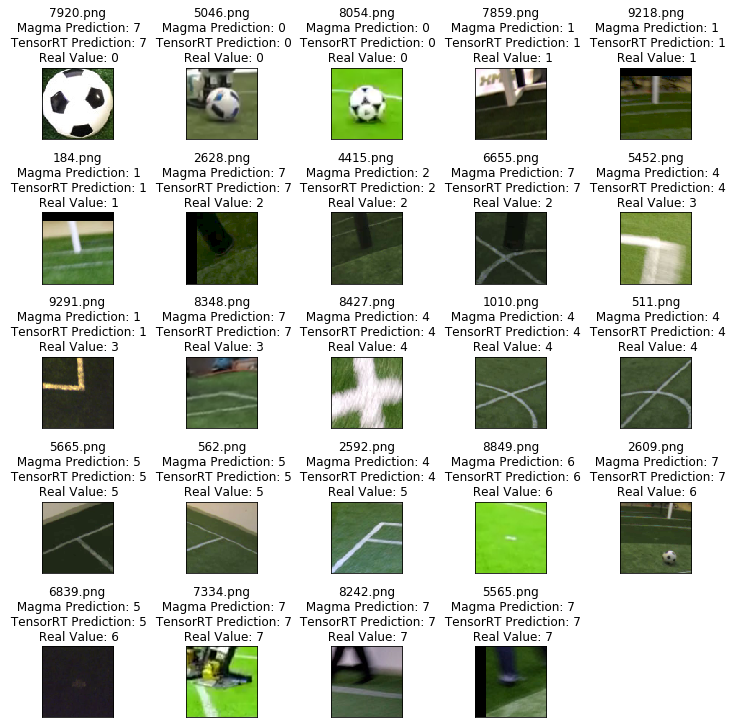

In [177]:
COLS = 5
rows = len(images)//COLS+1
print('COLS {}, rows {}'.format(COLS,rows))
fig, axes =  plt.subplots(nrows=rows, ncols=COLS, figsize=(10,10), constrained_layout=True)

# delete unused axes
for i in range( -(rows*COLS-len(images)),0):
    fig.delaxes(axes[rows-1,i])  

for idx, image in enumerate(images):
    col = idx%COLS
    row = idx//COLS
    
    img = load_img(path=image[0], color_mode='rgb', target_size=DATA_SHAPE)
    img = np.squeeze(img)
    axes[row,col].imshow(img,aspect='equal')
    axes[row,col].set_title('{}\n Magma Prediction: {}\n TensorRT Prediction: {}\n Real Value: {}'.format(
                        image[2], np.argmax(magma_pred[idx]),np.argmax(trt_pred[idx]), image[1]),fontsize=12)
    axes[row,col].tick_params(bottom=False, left=False,  labelleft=False, labelbottom=False)